# Exploratory Analysis

In [1]:
import numpy as np
import pandas as pd

import datetime

notebook_start_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_start_time}")

Notebook last run (end-to-end): 2025-02-03 18:26:11.366959


In [2]:
df = pd.read_csv("../data/high_diamond_ranked_10min.csv")

# See 0 Exploratory Analysis notebook for reasoning
drop_columns = [['gameId', 'blueEliteMonsters', 'redEliteMonsters', 'redGoldDiff', 'redExperienceDiff', 'redFirstBlood', 'redDeaths', 'blueDeaths']]
df = df.drop(columns=drop_columns)
df

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueDragons,blueHeralds,blueTowersDestroyed,...,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,0,0,0,16567,6.8,17047,197,55,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,1,1,1,17620,6.8,17438,240,52,24.0,1762.0
2,0,15,0,0,7,11,4,1,0,0,...,0,0,0,17285,6.8,17254,203,28,20.3,1728.5
3,0,43,1,0,4,5,5,0,1,0,...,0,0,0,16478,7.0,17961,235,47,23.5,1647.8
4,0,75,4,0,6,6,6,0,0,0,...,1,0,0,17404,7.0,18313,225,67,22.5,1740.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,4,5,1,0,0,...,0,0,0,15246,6.8,16498,229,34,22.9,1524.6
9875,1,54,0,0,6,4,8,1,0,0,...,0,0,0,15456,7.0,18367,206,56,20.6,1545.6
9876,0,23,1,0,6,7,5,0,0,0,...,1,0,0,18319,7.4,19909,261,60,26.1,1831.9
9877,0,14,4,1,2,3,3,1,0,0,...,0,0,0,15298,7.2,18314,247,40,24.7,1529.8


In [3]:
print(f"Number of features (columns): {len(df.columns)}")
print(f"Number of samples (rows): {len(df)}")

Number of features (columns): 34
Number of samples (rows): 9879
Number of games won by blue team: 4930 (49.90%)
Number of NaN values: 0


### Setting Expectations: Missing Features and Expected Accuracy

We don't have data about individual champions on each team (or champion's winrate), information about each player's ELO (which has surprisingly high variance), information about how long each player was in game (a player who connects late or disconnects early will obviously have a huge influence on the game), or even more granular data like player positions or item purchases. Predicting games based on data like player movement and item buys would likely be difficult (especially without enormous amounts of data). Predictions based on team composition is out of the question, with so many possible different team combinations (and team matchups) that getting even one game per possible combination of champions would require astronomical amounts of data. None of this data is available without making additional queries to Riot's API, so this is all to say these features would probably not be useful even if we did know them.

However, we are lacking two major pieces of data. First, we don't have information beyond the first ten minutes of each game. Both of these have enormous impacts on target accuracy for our model and the kinds of models we can train. As for having only ten minutes of data, this means we're only seeing the very beginnings of the game, while it's still in the first phase ("laning phase"). This means we are only able to predict game outcomes based on very early leads. However, team performance is not time homogenous, like in football: a football team scoring does not make it any easier or harder for them to score, so we could reasonably model football goals as independent. However, a player in League of Legends dying or performing poorly puts them at a disadvantage, increasingly the likelihood that they will continue to do poorly. This is good news for us: not only does performance in the first ten minutes predict player skill which predicts win likelihood, it actually predicts the likelihood of a team continuing to do poorly and eventually losing. Of course, by design there are frequent opportunities for teams to claw their way back into the game and make up for earlier disadvantages. We can conclude that the first ten minutes provides an imperfect but reasonably predictive window into a particular game.

Second, and the data we do have access to is not time series data. Having time series data would provide substantially more information into the game state: for example, all players on one team dying at the same time, or one player dying right before an objective spawns on the map, is devastating compared to dying individually at different times or dying at an relatively inconsequential time. However, time series data might also be substantially trickier to analyze accurately given the highly non-independent nature of events such as deaths, towers, gold, elite monsters, and so on. Furthermore, if we did have access to champions picks for each team, the winrates of each champion changes over time (as do many other aspects of the game) as some champions use game resources more effectively than others at certain points in the game.

In light of all this, I would consider accurate above 85% to be suspect and likely an indication of overfitting or some kind of bias. On the other hand, the information we do have should allow us to do substantially better than a coin flip: any worse than 65% would be disappointing. To summarize, **our target accuracy is between 65-85%.**

# Supervised Learning

### Train Test Split

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

y = df['blueWins']
X = df.drop(columns=['blueWins'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = X_train_scaler.transform(X_train)

### Logistic Regression

In [14]:
from sklearn import linear_model

reg = linear_model.LogisticRegression()

reg.fit(X_train_scaled, y_train)

logistic_regression_accuracy = accuracy_score(y_test, reg.predict(X_test))

print(f"Accuracy of logistic regression: {logistic_regression_accuracy:.3f}")

Accuracy of logistic regression: 0.692


/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Linear Discriminant Analysis

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_scaled, y_train)
lda_accuracy = accuracy_score(y_test, lda.predict(X_test))
print(f"Accuracy of linear discriminant analysis: {lda_accuracy:.3f}")

Accuracy of linear discriminant analysis: 0.690


/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LinearDiscriminantAnalysis was fitted without feature names
  warnings.warn(


### Quadratic Discriminant Analysis

In [16]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)
qda_accuracy = accuracy_score(y_test, qda.predict(X_test))
print(f"Accuracy of quadratic discriminant analysis: {qda_accuracy:.3f}")

/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuadraticDiscriminantAnalysis was fitted without feature names
  warnings.warn(


Accuracy of quadratic discriminant analysis: 0.503


In [17]:
# Covariance matrix of class 0 and 1 aren't full, so try increasing regularization
qda = QuadraticDiscriminantAnalysis(reg_param=1)
qda.fit(X_train_scaled, y_train)
qda_accuracy = accuracy_score(y_test, qda.predict(X_test))
print(f"Accuracy of quadratic discriminant analysis with regularization: {qda_accuracy:.3f}")

Accuracy of quadratic discriminant analysis with regularization: 0.729


/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuadraticDiscriminantAnalysis was fitted without feature names
  warnings.warn(


### Support Vector Machine

In [18]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train_scaled, y_train)
svm_accuracy = accuracy_score(y_test, clf.predict(X_test))
print(f"Accuracy of support vector machine: {svm_accuracy:.3f}")

/home/sam/Documents/projects/LeagueOfLosers/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Accuracy of support vector machine: 0.503


This accuracy is low! Suspicious of overfitting somehow

### Artifical Neural Nets

In [19]:
# Set random seed
import tensorflow as tf
tf.random.set_seed(42)

2025-01-30 22:30:53.343055: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-30 22:30:53.368057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738294253.398655   36392 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738294253.409712   36392 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-30 22:30:53.447075: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [20]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])
history = model_1.fit(X_train, y_train, epochs=20, verbose=1)
loss, accuracy = model_1.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/20


2025-01-30 22:30:56.150174: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5015 - loss: nan
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 10/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 11/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 12/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 13/20


In [21]:
# First model had NaN loss, maybe learning rate is too low
model_2 = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate=0.02), metrics=['accuracy'])
history = model_2.fit(X_train, y_train, epochs=20, verbose=1)
loss, accuracy = model_2.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5015 - loss: nan
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5028 - loss: nan
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 10/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 11/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
Epoch 12/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5028 - loss: nan
E

In [22]:
# Adjusting learning rate did nothing, try Adam
model_3 = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_3.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model_3.fit(X_train, y_train, epochs=20, verbose=1)
loss, accuracy = model_3.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6488 - loss: 261.8624
Epoch 2/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6411 - loss: 30.4131
Epoch 3/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6331 - loss: 28.9320
Epoch 4/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6380 - loss: 25.1456
Epoch 5/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6425 - loss: 20.8243
Epoch 6/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6485 - loss: 24.9188
Epoch 7/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6364 - loss: 31.3433
Epoch 8/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6508 - loss: 23.4515
Epoch 9/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6362 - loss: 26.5565
Epoch 10/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6495 - loss: 23.9239
Epoch 11/20
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6430 - loss: 20.9104
Epoch 12/20
247/247 ━━━━━━━━━━━━━━━━━━━━

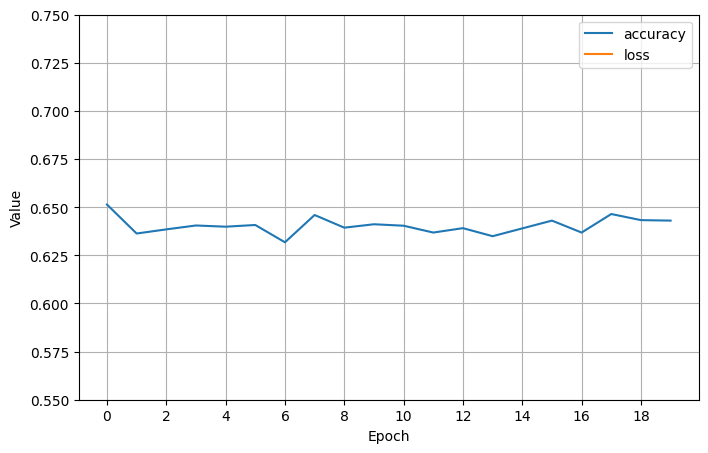

In [23]:
# We now have actual loss, so let's plot it
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 20, 2.0))
plt.show()


In [24]:
# See if accuracy increases with more epochs
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model_4.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_4.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6572 - loss: 158.4398
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6375 - loss: 27.6869
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6365 - loss: 24.5907
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6415 - loss: 27.7100
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6474 - loss: 22.2217
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6425 - loss: 16.4442
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6306 - loss: 19.1302
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6450 - loss: 24.1363
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6306 - loss: 17.6345
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6292 - loss: 18.9293
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6443 - loss: 26.3591
Epoch 12/100
247/247 ━━━━━━━━

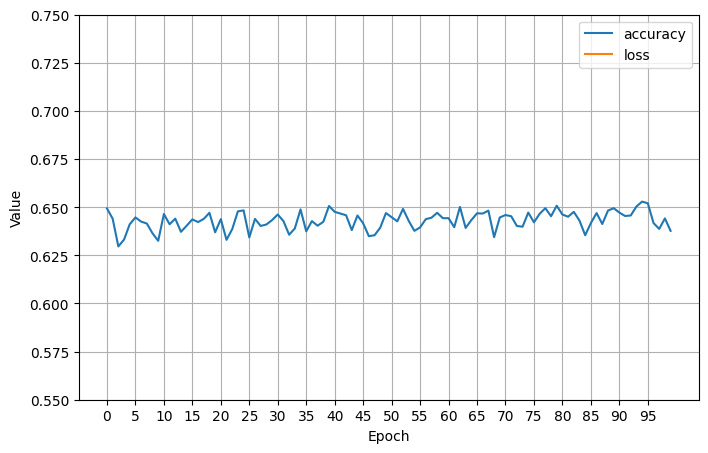

In [25]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [26]:
# See if accuracy increases with additional nonlinear layers
model_4 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_4.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
history = model_4.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_4.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6355 - loss: 31.5202
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6358 - loss: 5.9204
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6472 - loss: 2.9359
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6538 - loss: 3.1998
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6451 - loss: 2.1558
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6390 - loss: 1.2904
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6419 - loss: 1.1489
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7054 - loss: 0.6088
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7086 - loss: 0.5822
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7175 - loss: 0.5716
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7220 - loss: 0.5693
Epoch 12/100
247/247 ━━━━━━━━━━━━━━━━━━━

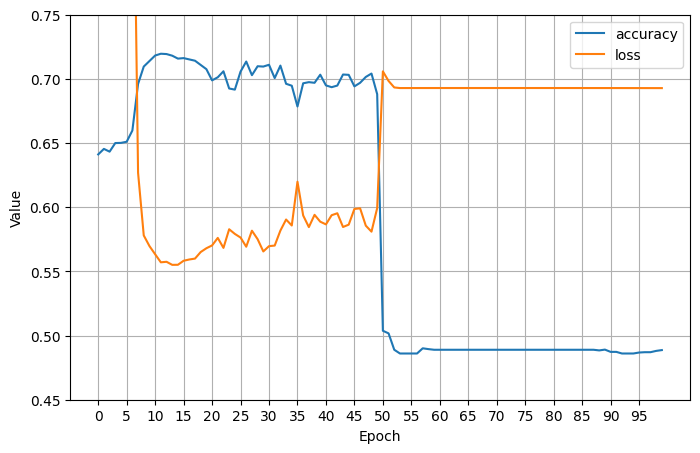

In [27]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.45, 0.75) # adjust y-axis to see full range
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [28]:
# Accuracy increased then decreased. See if smaller learning rate helps
model_5 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_5.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = model_5.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_5.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6000 - loss: 73.8072
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6558 - loss: 10.7958
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6394 - loss: 8.1660
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6292 - loss: 5.9220
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6346 - loss: 6.2784
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6290 - loss: 3.9113
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6433 - loss: 3.2399
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6358 - loss: 3.0855
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6324 - loss: 3.2436
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6445 - loss: 2.1010
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6467 - loss: 2.7463
Epoch 12/100
247/247 ━━━━━━━━━━━━━━━━━━

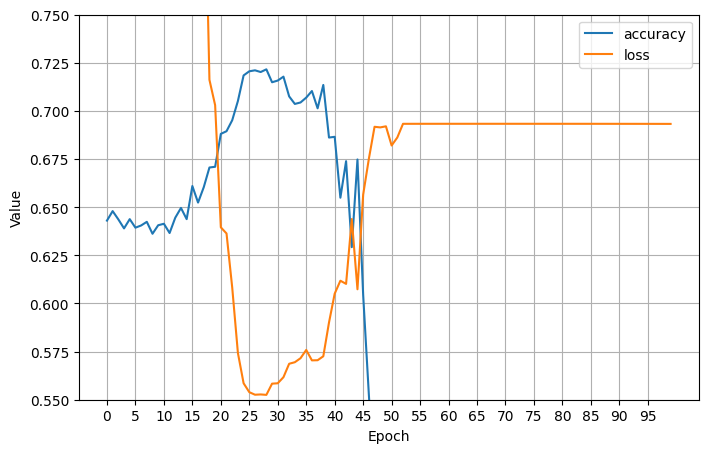

In [29]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [30]:
# See if even smaller learning rate helps
model_6 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_6.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_6.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_6.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6346 - loss: 227.1597
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6381 - loss: 10.5988
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6446 - loss: 6.5450
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6433 - loss: 5.0261
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6391 - loss: 5.2270
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6421 - loss: 3.7759
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6392 - loss: 3.6674
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6363 - loss: 3.0286
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6379 - loss: 3.4762
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6273 - loss: 3.2143
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6535 - loss: 2.0072
Epoch 12/100
247/247 ━━━━━━━━━━━━━━━━━

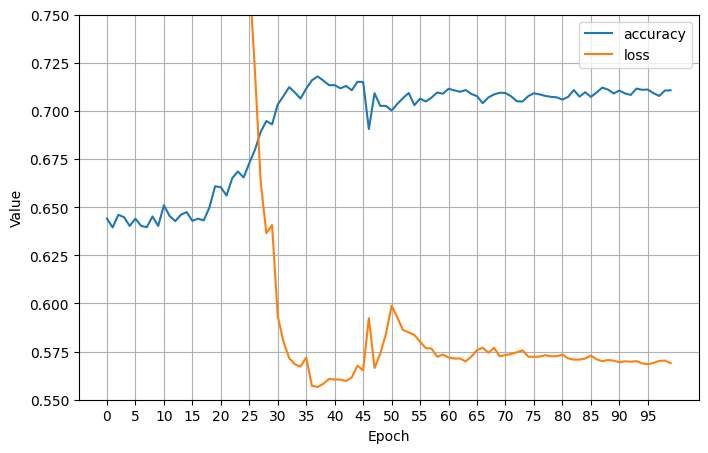

In [31]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [40]:
# The model accuracy seems to be approaching maximum we would expect with only ten minutes of data
# But let's try more neurons and see if that improves accuracy
model_7 = tf.keras.Sequential([
  tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(50, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(50),
  tf.keras.layers.Dense(50),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_7.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_7.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_7.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6275 - loss: 100.4277
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6282 - loss: 24.1194
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6421 - loss: 17.6095
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6473 - loss: 14.7363
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6360 - loss: 17.3899
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6491 - loss: 9.4922
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6509 - loss: 9.0863
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6427 - loss: 7.1631
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6416 - loss: 6.5214
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6462 - loss: 3.3859
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6498 - loss: 3.7925
Epoch 12/100
247/247 ━━━━━━━━━━━━━━

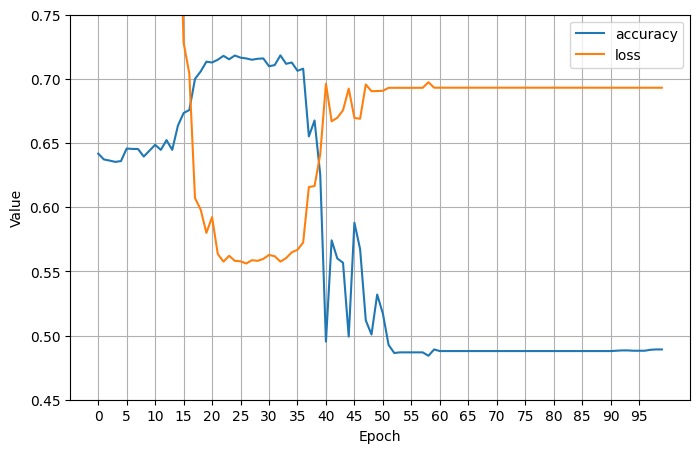

In [41]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.45, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [42]:
# That was terrible! See if different layers help instead
model_8 = tf.keras.Sequential([
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20, activation=tf.keras.activations.relu),
  tf.keras.layers.Dense(20),
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)
])

model_8.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), metrics=['accuracy'])
history = model_8.fit(X_train, y_train, epochs=100, verbose=1)
loss, accuracy = model_8.evaluate(X_test, y_test)
print(f"Loss of neural network: {loss:.3f}")
print(f"Accuracy of neural network: {accuracy:.3f}")

Epoch 1/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5721 - loss: 300.6400
Epoch 2/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6375 - loss: 5.7397
Epoch 3/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6363 - loss: 6.8948
Epoch 4/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6302 - loss: 7.7527
Epoch 5/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6440 - loss: 5.0236
Epoch 6/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6184 - loss: 5.0283
Epoch 7/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6434 - loss: 4.1031
Epoch 8/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6352 - loss: 4.8615
Epoch 9/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6336 - loss: 3.6846
Epoch 10/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6374 - loss: 3.5365
Epoch 11/100
247/247 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6599 - loss: 3.4531
Epoch 12/100
247/247 ━━━━━━━━━━━━━━━━━━

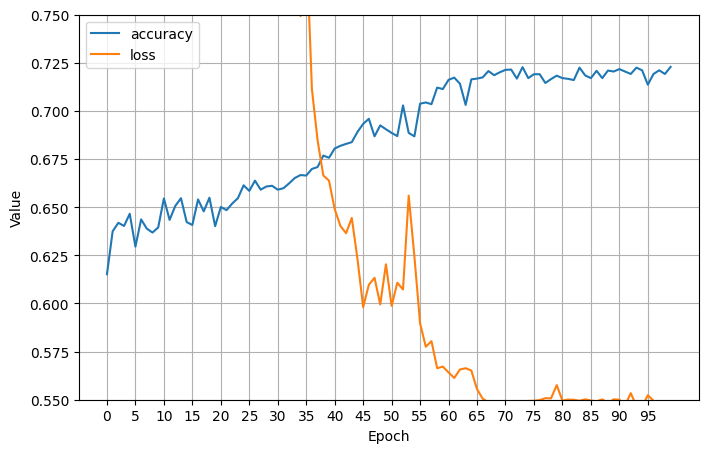

In [43]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0.55, 0.75)
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.xticks(np.arange(0, 100, 5.0))
plt.show()

In [44]:
notebook_end_time = datetime.datetime.now()
print(f"Notebook last run (end-to-end): {notebook_end_time} (duration: {notebook_end_time - notebook_start_time})")

Notebook last run (end-to-end): 2025-01-30 22:51:35.464774 (duration: 0:21:19.635914)
